In [1]:
from nasbench import api
from hypernets.benchmark.nas_bench_101 import NasBench101
from hypernets.searchers.random_searcher import RandomSearcher
from hypernets.searchers.mcts_searcher import MCTSSearcher
from hypernets.searchers.evolution_searcher import EvolutionSearcher
from hypernets.core.meta_learner import MetaLearner
from hypernets.core.trial import get_default_trail_store, TrailHistory, DiskTrailStore, Trail
from tests import test_output_dir
import matplotlib.pyplot as plt
import random

/Users/jack/opt/anaconda3/envs/hypernets/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
nasbench = api.NASBench('/Users/jack/workspace/NAS/nasbench/nasbench_only108.tfrecord')
hyn_nasbench = NasBench101(7, ops=['conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3'])

Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 85 seconds


In [3]:
def valid_space_sample(space_sample):
    matrix, ops = hyn_nasbench.sample2spec(space_sample)
    model_spec = api.ModelSpec(matrix=matrix, ops=ops)
    return nasbench.is_valid(model_spec)


def run_searcher(searcher, max_trails=None, max_time_budget=5e6, use_meta_learner=True):
    history = TrailHistory('max')
    if use_meta_learner:
        disk_trail_store = DiskTrailStore(f'{test_output_dir}/trail_store')
        disk_trail_store.clear_history()
        meta_learner = MetaLearner(history, 'nas_bench_101', disk_trail_store)
        searcher.set_meta_learner(meta_learner)

    nasbench.reset_budget_counters()
    times, best_valids, best_tests = [0.0], [0.0], [0.0]
    trail_no = 0
    while True:
        trail_no += 1
        if max_trails is not None and trail_no > max_trails:
            break

        sample = searcher.sample()
        matrix, ops = hyn_nasbench.sample2spec(sample)
        model_spec = api.ModelSpec(matrix=matrix, ops=ops)
        data = nasbench.query(model_spec)

        if data['validation_accuracy'] > best_valids[-1]:
            best_valids.append(data['validation_accuracy'])
            best_tests.append(data['test_accuracy'])
        else:
            best_valids.append(best_valids[-1])
            best_tests.append(best_tests[-1])
        time_spent, _ = nasbench.get_budget_counters()
        times.append(time_spent)
        reward = data['test_accuracy']
        trail = Trail(sample, trail_no, reward, data['training_time'])
        history.append(trail)
        searcher.update_result(sample, reward)

        if time_spent > max_time_budget:
            # Break the first time we exceed the budget.
            break

    return times, best_valids, best_tests

In [ ]:
random_data = []
evolution_data = []
mcts_data = []
for repeat in range(5):
    print('Running repeat %d' % (repeat + 1))

    rs_searcher = RandomSearcher(hyn_nasbench.get_space, space_sample_validation_fn=valid_space_sample)
    times, best_valid, best_test = run_searcher(rs_searcher,max_trails=200)
    random_data.append((times, best_valid, best_test))

    evol_searcher = EvolutionSearcher(hyn_nasbench.get_space,50,20,regularized=False, optimize_direction='max',space_sample_validation_fn=valid_space_sample)
    times, best_valid, best_test = run_searcher(evol_searcher,max_trails=200, use_meta_learner=True)
    evolution_data.append((times, best_valid, best_test))

    mcts_searcher = MCTSSearcher(hyn_nasbench.get_space, optimize_direction='max',space_sample_validation_fn=valid_space_sample)
    times, best_valid, best_test = run_searcher(mcts_searcher,max_trails=200, use_meta_learner=True)
    mcts_data.append((times, best_valid, best_test))


Text(0.5, 1.0, 'MCTS search trajectories (red=validation, blue=test)')

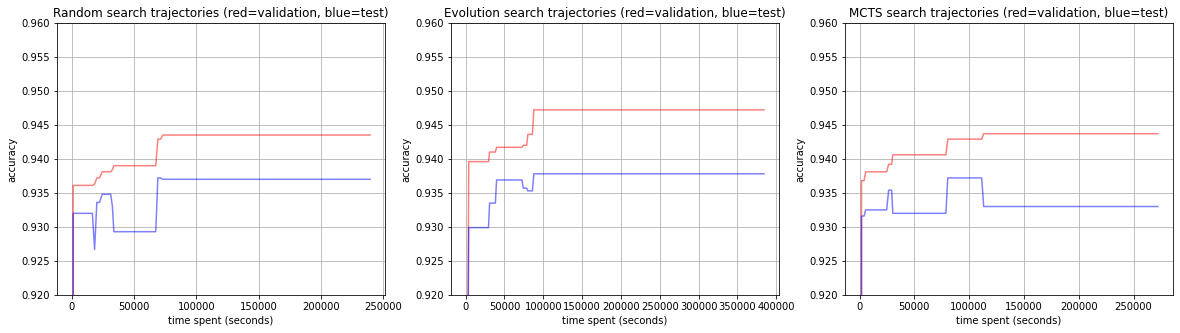

In [19]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
for times, best_valid, best_test in random_data:
    plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
    plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Random search trajectories (red=validation, blue=test)')


plt.subplot(1, 3, 2)
for times, best_valid, best_test in evolution_data:
    plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
    plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Evolution search trajectories (red=validation, blue=test)')

plt.subplot(1, 3, 3)
for times, best_valid, best_test in mcts_data:
    plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
    plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('MCTS search trajectories (red=validation, blue=test)')


In [ ]:
mcts_data[0][2][-1],evolution_data[0][2][-1],random_data[0][2][-1]

In [ ]:
mcts_data[0][1][-1],evolution_data[0][1][-1],random_data[0][1][-1]

In [ ]:
import numpy as np
np.max(mcts_data[0][1]),np.max(evolution_data[0][1]),np.max(random_data[0][1])

In [ ]:
np.max(mcts_data[0][2]),np.max(evolution_data[0][2]),np.max(random_data[0][2])

In [ ]:
mcts_data[0][2].index(np.max(mcts_data[0][2])),evolution_data[0][2].index(np.max(evolution_data[0][2])),random_data[0][2].index(np.max(random_data[0][2]))

In [ ]:
mcts_data[0][1].index(np.max(mcts_data[0][1])),evolution_data[0][1].index(np.max(evolution_data[0][1])),random_data[0][1].index(np.max(random_data[0][1]))

(0.9378004670143127, 0.9378004670143127, 0.9378004670143127)

In [10]:
mcts_data[0][1][-1],evolution_data[0][1][-1],random_data[0][1][-1]

(0.9472155570983887, 0.9472155570983887, 0.9472155570983887)

In [24]:
import numpy as np
np.max(mcts_data[0][1]),np.max(evolution_data[0][1]),np.max(random_data[0][1])

(0.9437099099159241, 0.9472155570983887, 0.9435096383094788)

In [23]:
np.max(mcts_data[0][2]),np.max(evolution_data[0][2]),np.max(random_data[0][2])

(0.9371995329856873, 0.9378004670143127, 0.9371995329856873)

In [22]:
mcts_data[0][2].index(np.max(mcts_data[0][2])),evolution_data[0][2].index(np.max(evolution_data[0][2])),random_data[0][2].index(np.max(random_data[0][2]))

(72, 67, 61)

In [25]:
mcts_data[0][1].index(np.max(mcts_data[0][1])),evolution_data[0][1].index(np.max(evolution_data[0][1])),random_data[0][1].index(np.max(random_data[0][1]))

(98, 67, 64)